# Getting started with Owl-ViT

In this notebook, we are going to run the [OWL-ViT](https://arxiv.org/abs/2205.06230) model (an open-vocabulary object detection model) by Google Research on scikit-image samples images. 

## OWL-ViT: A Quick Intro
OWL-ViT is an open-vocabulary object detector. Given an image and one or multiple free-text queries, it finds objects matching the queries in the image. Unlike traditional object detection models, OWL-ViT is not trained on labeled object datasets and leverages multi-modal representations to perform open-vocabulary detection. 

OWL-ViT uses CLIP with a ViT-like Transformer as its backbone to get multi-modal visual and text features. To use CLIP for object detection, OWL-ViT removes the final token pooling layer of the vision model and attaches a lightweight classification and box head to each transformer output token. Open-vocabulary classification is enabled by replacing the fixed classification layer weights with the class-name embeddings obtained from the text model. The authors first train CLIP from scratch and fine-tune it end-to-end with the classification and box heads on standard detection datasets using a bipartite matching loss. One or multiple text queries per image can be used to perform zero-shot text-conditioned object detection.

![owlvit architecture](https://raw.githubusercontent.com/google-research/scenic/a41d24676f64a2158bfcd7cb79b0a87673aa875b/scenic/projects/owl_vit/data/owl_vit_schematic.png)

## Set-up environment

First, we install the HuggingFace Transformers library (from source for now, as the model was recently added to the library and is under active development). This might take a few minutes.

In [1]:
!pip install -q git+https://github.com/huggingface/transformers.git

  Installing build dependencies ... done
  Getting requirements to build wheel ... done
  Preparing metadata (pyproject.toml) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 224.5/224.5 kB 5.5 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 7.8/7.8 MB 66.4 MB/s eta 0:00:00


**Optional:** Install Pillow, matplotlib and OpenCV if you are running this notebook locally.

In [2]:
!pip install Pillow
!pip install matplotlib
!pip install opencv-python

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


We also quickly upload some telemetry - this tells us which examples and software versions are getting used so we know where to prioritize our maintenance efforts. We don't collect (or care about) any personally identifiable information, but if you'd prefer not to be counted, feel free to skip this step or delete this cell entirely.

In [3]:
from transformers.utils import send_example_telemetry

send_example_telemetry("zeroshot_object_detection_with_owlvit_notebook", framework="pytorch")

## Load pre-trained model and processor

Let's first apply the image preprocessing and tokenize the text queries using `OwlViTProcessor`. The processor will resize the image(s), scale it between [0-1] range and normalize it across the channels using the mean and standard deviation specified in the original codebase.


Text queries are tokenized using a CLIP tokenizer and stacked to output tensors of shape [batch_size * num_max_text_queries, sequence_length]. If you are inputting more than one set of (image, text prompt/s), num_max_text_queries is the maximum number of text queries per image across the batch. Input samples with fewer text queries are padded. 

In [4]:
from transformers import OwlViTProcessor, OwlViTForObjectDetection

model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
processor = OwlViTProcessor.from_pretrained("google/owlvit-base-patch32")

In [5]:
import cv2
import skimage
import numpy as np
from PIL import Image


In [6]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

## Forward pass

Now we can pass the inputs to our OWL-ViT model to get object detection predictions. 

`OwlViTForObjectDetection` model outputs the prediction logits, boundary boxes and class embeddings, along with the image and text embeddings outputted by the `OwlViTModel`, which is the CLIP backbone.

In [7]:
# Set model in evaluation mode
#model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
model = model.to(device)
model.eval()

OwlViTForObjectDetection(
  (owlvit): OwlViTModel(
    (text_model): OwlViTTextTransformer(
      (embeddings): OwlViTTextEmbeddings(
        (token_embedding): Embedding(49408, 512)
        (position_embedding): Embedding(16, 512)
      )
      (encoder): OwlViTEncoder(
        (layers): ModuleList(
          (0-11): 12 x OwlViTEncoderLayer(
            (self_attn): OwlViTAttention(
              (k_proj): Linear(in_features=512, out_features=512, bias=True)
              (v_proj): Linear(in_features=512, out_features=512, bias=True)
              (q_proj): Linear(in_features=512, out_features=512, bias=True)
              (out_proj): Linear(in_features=512, out_features=512, bias=True)
            )
            (layer_norm1): LayerNorm((512,), eps=1e-05, elementwise_affine=True)
            (mlp): OwlViTMLP(
              (activation_fn): QuickGELUActivation()
              (fc1): Linear(in_features=512, out_features=2048, bias=True)
              (fc2): Linear(in_features=2048, out_

## Draw predictions on image

Let's draw the predictions / found objects on the input image. Remember the found objects correspond to the input text queries. 

## One-shot / image-guided object detection
Instead of performing zero-shot detection with text inputs, we can use the `OwlViTForObjectDetection.image_guided_detection()` method to query an input image with a query / example image and detect similar looking objects. To do this, we simply pass in `query_images` instead of text to the processor to get the `query_pixel_values`. Note that, unlike text input, `OwlViTProcessor` expects one query image per target image we'd like to query for similar objects. We will also see that the output and post-processing of one-shot object detection is very similar to the zero-shot / text-guided detection.

Let's try this out by querying an image with cats with another random cat image. For this part of the demo, we will perform image-guided object detection, post-process the results and display the predicted boundary boxes on the original input image using OpenCV.

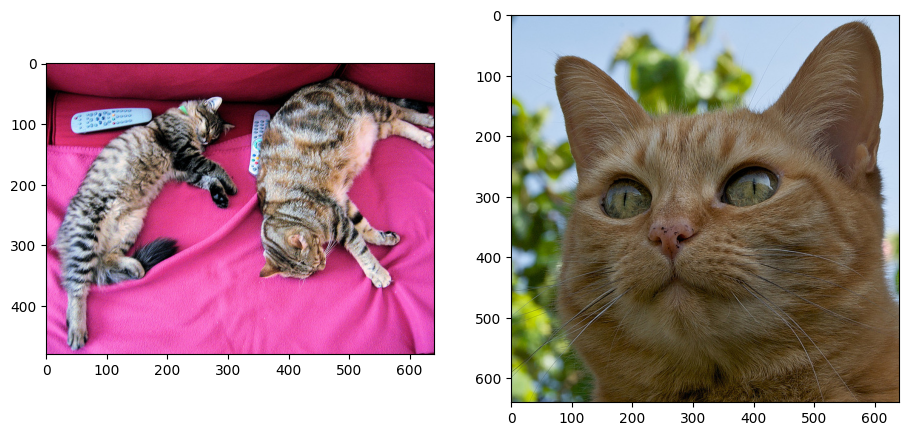

In [9]:
import matplotlib.pyplot as plt
import cv2
import requests
from matplotlib import rcParams

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Input image
url = "http://images.cocodataset.org/val2017/000000039769.jpg"
image = Image.open(requests.get(url, stream=True).raw)
target_sizes = torch.Tensor([image.size[::-1]])

# Query image
query_url = "http://images.cocodataset.org/val2017/000000524280.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(query_image)

In [10]:
# Process input and query image
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [11]:
# Get predictions
with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

logits: shape of torch.Size([1, 576, 1])
image_embeds: shape of torch.Size([1, 24, 24, 768])
query_image_embeds: shape of torch.Size([1, 24, 24, 768])
target_pred_boxes: shape of torch.Size([1, 576, 4])
query_pred_boxes: shape of torch.Size([1, 576, 4])
class_embeds: shape of torch.Size([1, 576, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


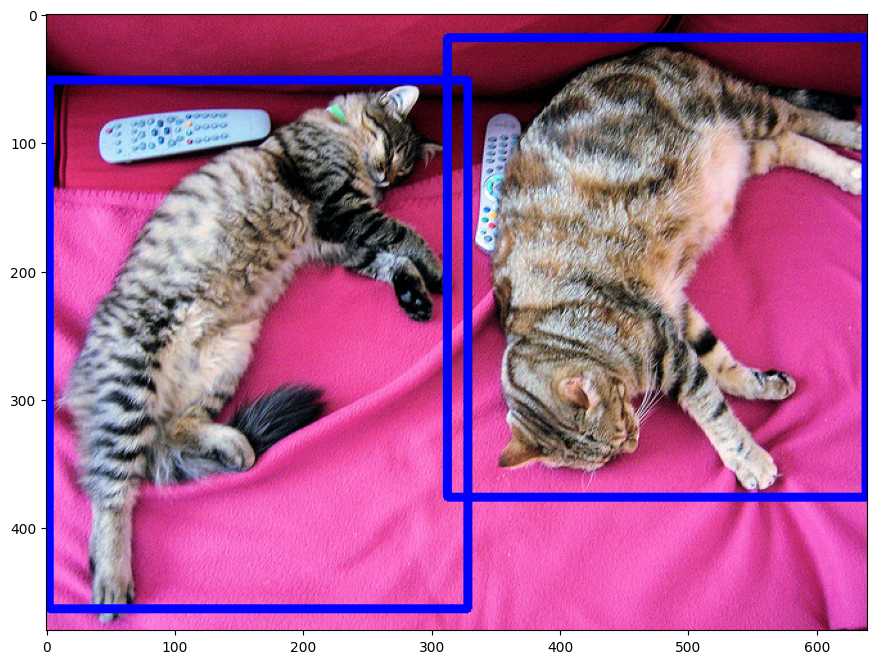

In [12]:
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu() 

results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]

    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25 
        
plt.imshow(img[:,:,::-1])

# 亞古獸

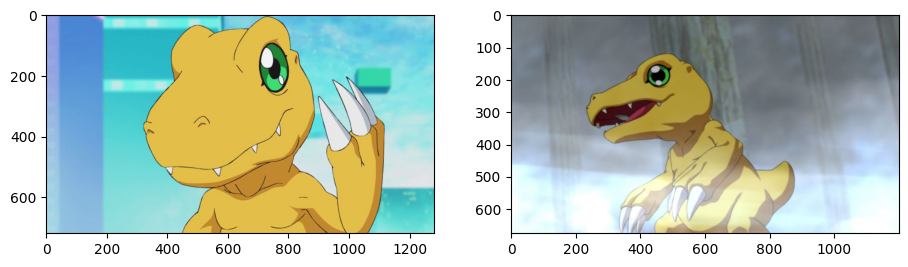

In [13]:
import cv2
import requests
from matplotlib import rcParams

# Set figure size
%matplotlib inline
rcParams['figure.figsize'] = 11 ,8

# Input image
url = "https://i.pinimg.com/originals/8f/25/4b/8f254b2ccff50020269d2b15d766d88b.jpg"
image = Image.open(requests.get(url, stream=True).raw)
target_sizes = torch.Tensor([image.size[::-1]])

# Query image
query_url = "https://assets.gamepur.com/wp-content/uploads/2022/07/29191902/DIGIMON-SURVIVE_20220729122707-1.jpg"
query_image = Image.open(requests.get(query_url, stream=True).raw)

# Display input image and query image
fig, ax = plt.subplots(1,2)
ax[0].imshow(image)
ax[1].imshow(query_image)

In [14]:
# Process input and query image
text_queries = ['agumon']
inputs = processor(images=image, query_images=query_image, return_tensors="pt").to(device)

# Print input names and shapes
for key, val in inputs.items():
    print(f"{key}: {val.shape}")

query_pixel_values: torch.Size([1, 3, 768, 768])
pixel_values: torch.Size([1, 3, 768, 768])


In [15]:
import torch

# Use GPU if available
if torch.cuda.is_available():
    device = torch.device("cuda")
else:
    device = torch.device("cpu")

In [16]:
# Get predictions
model = OwlViTForObjectDetection.from_pretrained("google/owlvit-base-patch32")
model = model.to(device)
model.eval()

with torch.no_grad():
  outputs = model.image_guided_detection(**inputs)

for k, val in outputs.items():
    if k not in {"text_model_output", "vision_model_output"}:
        print(f"{k}: shape of {val.shape}")

print("\nVision model outputs")
for k, val in outputs.vision_model_output.items():
    print(f"{k}: shape of {val.shape}") 

logits: shape of torch.Size([1, 576, 1])
image_embeds: shape of torch.Size([1, 24, 24, 768])
query_image_embeds: shape of torch.Size([1, 24, 24, 768])
target_pred_boxes: shape of torch.Size([1, 576, 4])
query_pred_boxes: shape of torch.Size([1, 576, 4])
class_embeds: shape of torch.Size([1, 576, 512])

Vision model outputs
last_hidden_state: shape of torch.Size([1, 577, 768])
pooler_output: shape of torch.Size([1, 768])


In [17]:
img = cv2.cvtColor(np.array(image), cv2.COLOR_BGR2RGB)
outputs.logits = outputs.logits.cpu()
outputs.target_pred_boxes = outputs.target_pred_boxes.cpu() 

results = processor.post_process_image_guided_detection(outputs=outputs, threshold=0.6, nms_threshold=0.3, target_sizes=target_sizes)
boxes, scores = results[0]["boxes"], results[0]["scores"]

# Draw predicted bounding boxes
for box, score in zip(boxes, scores):
    box = [int(i) for i in box.tolist()]
    cx,cy,x,y=box
    img = cv2.rectangle(img, box[:2], box[2:], (255,0,0), 5)
    if box[3] + 25 > 768:
        y = box[3] - 10
    else:
        y = box[3] + 25 
        

Text(198, 0, 'Agumon1.0')

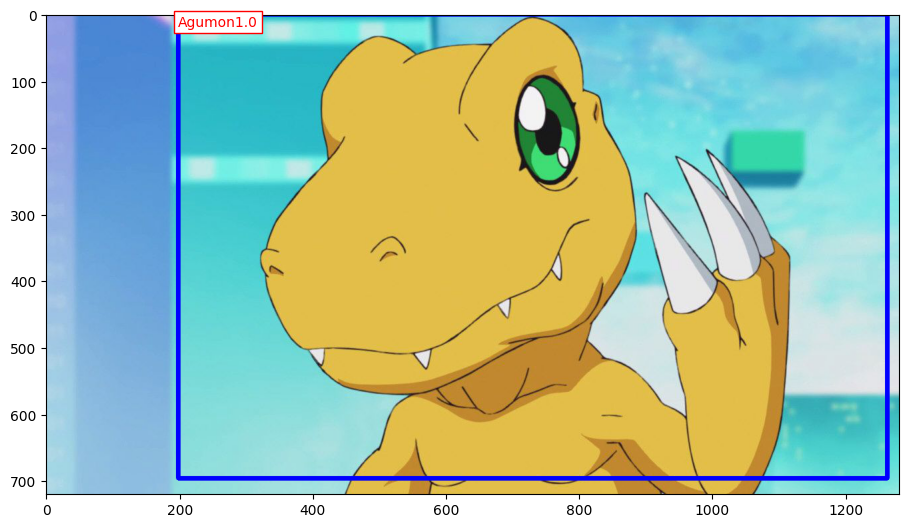

In [18]:
plt.imshow(img[:,:,::-1])
plt.text(
          cx ,
          cy ,
          "Agumon"+str(round(score.tolist(),2)) ,
          ha="left",
          va="top",
          color="red",
          bbox={
              "facecolor": "white",
              "edgecolor": "red",
              "boxstyle": "square,pad=.3"
          })